# "영화는 왜 성공할까? 캐글 영화 데이터로 보는 평점과 흥행의 관계"

## 1. 프로젝트 개요

In [13]:
'''
캐글 영화 데이터를 활용한 분석 프로젝트
목표 : 영화의 평점과 수익간의 관계를 탐색하고 간단한 예측 모델 실험
흥행이 된 영화에는 어떤 특성이 있을까 라는 생각에서 비롯된 프로젝트
'''

'\n캐글 영화 데이터를 활용한 분석 프로젝트\n목표 : 영화의 평점과 수익간의 관계를 탐색하고 간단한 예측 모델 실험\n흥행이 된 영화에는 어떤 특성이 있을까 라는 생각에서 비롯된 프로젝트\n'

## 2. 데이터셋 소개

In [14]:
'''
출처 페이지 : https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/ (Kaggle)
데이터 수 : 1083289

주요 컬럼 :
vote_average : 평점
revenue, budget : 수익, 제작비
genres : 장르


평점과 수익간의 관계를 파악하기 위해 평점, 수익, 제작비, 장르 컬럼을 사용
'''

'\n출처 페이지 : https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/ (Kaggle)\n데이터 수 : 1083289\n\n주요 컬럼 :\nvote_average : 평점\nrevenue, budget : 수익, 제작비\ngenres : 장르\n\n\n평점과 수익간의 관계를 파악하기 위해 평점, 수익, 제작비, 장르 컬럼을 사용\n'

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 영화 데이터셋 불러오기
df = pd.read_csv("TMDB_movie_dataset_v11.csv")

In [16]:
# 판다스 출력 옵션: 컬럼 많이 보여주기
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)

# 사용할 핵심 컬럼이 실제로 데이터셋에 존재하는지 확인
# 이번단계에서 필요한 컬럼 목록
required_cols = ["vote_average", "revenue", "budget", "genres"]

# 원본 df에 없는 컬럼이 있는지 체크
missing = [c for c in required_cols if c not in df.columns]

# 만약 빠진 컬럼이 있다면 지금 바로 알려주고 진행을 멈춤
if missing:
    print("\n[경고] 다음 컬럼이 존재하지 않음:", missing)
    print("→ CSV의 실제 컬럼명을 알려주시면 매핑해서 처리")
else:
    print("\n필요 컬럼이 모두 존재")



필요 컬럼이 모두 존재


## 3. 분석 방향 설정

In [17]:
'''
'영화의 성공'을 어떻게 정의할까?
이 프로젝트 에서는 수익이 제작비보다 많으면 '성공'이라 정의
 -> ROI(Retrun On Investment) > 1

단 영화의 성공에는 제작비, 배우, 홍보 요소등 많은 요소가 있지만 
이 프로젝트에서는 평점, 수익, 제작비의 데이터만 사용하여 분석함
'''

"\n'영화의 성공'을 어떻게 정의할까?\n이 프로젝트 에서는 수익이 제작비보다 많으면 '성공'이라 정의\n -> ROI(Retrun On Investment) > 1\n\n단 영화의 성공에는 제작비, 배우, 홍보 요소등 많은 요소가 있지만 \n이 프로젝트에서는 평점, 수익, 제작비의 데이터만 사용하여 분석함\n"

## 4. 데이터 전처리 개요

In [18]:
'''
대용량 CSV(데이터셋)에는 문자열로 섞인 숫자(ex: '1,000')가 있을수 있음
일괄적으로 깨끗한 숫자(float)로 변환해야함
'''

"\n대용량 CSV(데이터셋)에는 문자열로 섞인 숫자(ex: '1,000')가 있을수 있음\n일괄적으로 깨끗한 숫자(float)로 변환해야함\n"

In [19]:
def to_numeric_safe(x):
    '''
    문자열/숫자 섞인 데이터를 안전하게 숫자형으로 바꾸는 함수.
    숫자로 바꾸지 못할 경우 NaN으로 처리
    '''

    try:
        # 문자열에 콤마가 포함될 수 있어 제거
        if isinstance(x, str):
            x = x.replace(",", "").strip()

        # 숫자로 변환 (실패시 NaN)
        return pd.to_numeric(x, errors = "coerce")
    except Exception:
        return np.nan


# 평점 / 수익 / 제작비 컬럼을 숫자형으로 강제 변환
for col in ["vote_average", "revenue", "budget"]:
    if col in df.columns:
        df[col] = df[col].apply(to_numeric_safe)

# print(df[["vote_average", "revenue", "budget"]].describe())

In [20]:
'''
TDMB 데이터의 genres의 데이터 형태는 아래 중 하나일 수 있음
 - JSON 문자열 : "[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name': 'Action'}]"
 - 콤마로 구분된 단순 문자열: "Drama,Action"
 - 이미 리스트 형태(희소)
따라서 최대한 범용적으로 '장르 이름 리스트'로 변환합니다.
'''

import json

def parse_genres(val):
    '''
    genres 컬럼을 '장르 이름들의 리스트'로 변환
     - JSON 문자열 -> 각 dict의 name만 추출
     - 콤마 구분 문자열 -> 각 토큰을 strip하여 리스트로
     - 이미 리스트 -> 문자열 목록으로 통일
     - 그 외/ 실패 -> 빈 리스트([])
    '''

    # 이미 파싱된 리스트 형태
    if isinstance(val, list):
        names = []
        for item in val:
            if isinstance(item, dict) and "name" in item:
                names.append(str(item["name"]).strip())
            else:
                names.append(str(item).strip())
        return names


    # 문자열인 경우
    if isinstance(val, str):
        s = val.strip()

        # 빈 문자열이나 빈 리스트 일경우 빈 리스트 반환
        if s == "" or s == "[]":
            return []

        # JSON 문자열일 가능성 : 작은 따옴표를 큰 따옴표로 바꿔서 파싱시도
        try:
            maybe_json = s.replace("'", '"')
            obj = json.loads(maybe_json)
            if isinstance(obj, list):
                names = []
                for item in obj:
                    if isinstance(item, dict) and "name" in item:
                        names.append(str(item["name"]).strip())
                    else:
                        names.append(str(item).strip())
                return names
        except Exception:
            pass
            
        if "," in s:
            return [token.strip() for token in s.split(",") if token.strip()]

        # 위 어떤 경우도 아니면 단일 문자열을 리스트로 감싸서 반환
        return [s]

    # 그 외 타입(숫자/NaN 등)은 빈 리스트 처리
    return []

df["genres_parsed"] = df["genres"].apply(parse_genres)
print(df["genres_parsed"])

0                   [Action, Science Fiction, Adventure]
1                    [Adventure, Drama, Science Fiction]
2                       [Drama, Action, Crime, Thriller]
3          [Action, Adventure, Fantasy, Science Fiction]
4                   [Science Fiction, Action, Adventure]
                               ...                      
1268751                                         [Horror]
1268752                                 [Drama, Romance]
1268753                                               []
1268754                                 [Romance, Drama]
1268755                                               []
Name: genres_parsed, Length: 1268756, dtype: object


In [21]:
'''
하나의 영화에는 다양한 장르가 혼합되어 만들어짐
예를 들어 인셉션에는 액션, SF, 어드벤처가 포함되며 특히 드라마, 다큐멘터리 이 장르는 많은 영화에 포함되어 있기때문에
이 두 장르에 대해서는 단일 장르에 대해서만 인정하고 다른 장르안에도 포함되어 있을경우 제외하고 진행함
'''

'\n하나의 영화에는 다양한 장르가 혼합되어 만들어짐\n예를 들어 인셉션에는 액션, SF, 어드벤처가 포함되며 특히 드라마, 다큐멘터리 이 장르는 많은 영화에 포함되어 있기때문에\n이 두 장르에 대해서는 단일 장르에 대해서만 인정하고 다른 장르안에도 포함되어 있을경우 제외하고 진행함\n'

In [22]:
exclude_if_combined = ["Drama", "Documentary"]

def filter_genres(genres_list):
    '''
    장르 리스트에서 드라마와 다큐멘터리는 단일 장르일때만 유지
    다른 장르와 같이 있을경우 제거
    '''

    if not isinstance(genres_list, list):
        return []

    # 장르가 1개뿐이면 그대로 유지
    if len(genres_list) == 1:
        return genres_list

    filtered = [g for g in genres_list if g not in exclude_if_combined]
    return filtered

df["genres_filtered"] = df["genres_parsed"].apply(filter_genres)

# 5. EDA 1 - 평점 분포

In [23]:
'''
우리는 평점을 기준으로 영화의 성공이냐 아니냐를 나눌것이기에 이 평점이 어떻게 분포되어 있는지 알아야함.
그 이유는 어떤 영화는 유명하지 않고 흥행했다고 보기 힘들지만 적은 투표수로 높은 평점을 받았을 수 있으므로 
평점의 분포를 확인하여 일정 투표수 이하는 제외하는것이 필요(컷오프)

이런 컷오프를 하기 위해서는 평점이 어떻게 분포되어있는지 알아야 하기떄문에 이 과정을 거침
'''

'\n우리는 평점을 기준으로 영화의 성공이냐 아니냐를 나눌것이기에 이 평점이 어떻게 분포되어 있는지 알아야함.\n그 이유는 어떤 영화는 유명하지 않고 흥행했다고 보기 힘들지만 적은 투표수로 높은 평점을 받았을 수 있으므로 \n평점의 분포를 확인하여 일정 투표수 이하는 제외하는것이 필요(컷오프)\n\n이런 컷오프를 하기 위해서는 평점이 어떻게 분포되어있는지 알아야 하기떄문에 이 과정을 거침\n'

In [24]:
# 결측 제거
vote_avg_clean = df["vote_average"].dropna()

# 기본 통계

# print("=== 평점 기초 통계 === ")
# print(vote_avg_clean.describe())  # count, mean, std, min, max 등
# print("\n평균 평점:", round(vote_avg_clean.mean(), 2))
# print("중앙값:", round(vote_avg_clean.median(), 2))

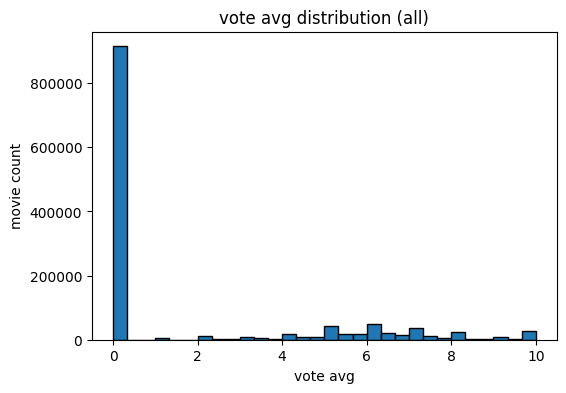

In [25]:
# 히스토그램
plt.figure(figsize=(6,4))
plt.hist(vote_avg_clean, bins=30, edgecolor='black')
plt.title("vote avg distribution (all)")
plt.xlabel("vote avg")
plt.ylabel("movie count")
plt.show()


=== 투표수 기초 통계 ===
count    1.268756e+06
mean     1.690881e+01
std      3.015261e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.449500e+04
Name: vote_count, dtype: float64
투표수 ≤ 4 영화 비율: 90.08%


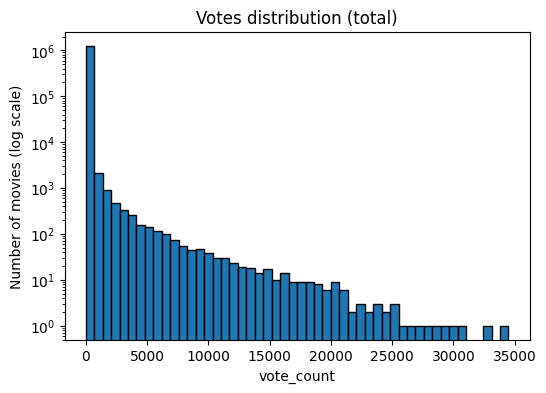

In [26]:
if "vote_count" in df.columns:
    vote_count_clean = df["vote_count"].dropna()
    print("\n=== 투표수 기초 통계 ===")
    print(vote_count_clean.describe())

    # 투표수가 4 이하인 영화 비율
    low_vote_ratio = (vote_count_clean <= 4).mean() * 100
    print(f"투표수 ≤ 4 영화 비율: {low_vote_ratio:.2f}%")

    plt.figure(figsize=(6,4))
    plt.hist(vote_count_clean, bins=50, edgecolor='black')
    plt.yscale("log")  # 투표수 범위가 넓어서 로그축
    plt.title("Votes distribution (total)")
    plt.xlabel("vote_count")
    plt.ylabel("Number of movies (log scale)")
    plt.show()

In [27]:
'''
90퍼센트의 영화는 4표도 받지 못했고, 4표이하의 영화는 평점을 이용하기에는 너무 적기에 컷오프함
'''

'\n90퍼센트의 영화는 4표도 받지 못했고, 4표이하의 영화는 평점을 이용하기에는 너무 적기에 컷오프함\n'


Data size after cutoff application: (146702, 26)
Average score after cutoff application: 5.96


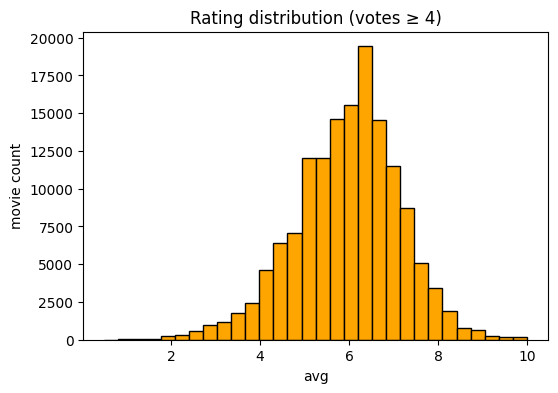

In [28]:
if "vote_count" in df.columns:
    df_cutoff = df[df["vote_count"] >= 4].copy()
    print("\nData size after cutoff application:", df_cutoff.shape)
    
    vote_avg_cutoff = df_cutoff["vote_average"].dropna()
    print("Average score after cutoff application:", round(vote_avg_cutoff.mean(), 2))
    
    plt.figure(figsize=(6,4))
    plt.hist(vote_avg_cutoff, bins=30, edgecolor='black', color='orange')
    plt.title("Rating distribution (votes ≥ 4)")
    plt.xlabel("avg")
    plt.ylabel("movie count")
    plt.show()

In [29]:
'''
컷오프 전보다 데이터 수는 확연히 줄어들었지만 신뢰도있는 평점분포 데이터가 만들어짐
컷오프 전보다 컷오프 후 평균평점이 낮아진것으로 보아 표본이 적은 영화에서 높은 평점이 많았다는 것을 알수있음

평점분포 특징으로는 5~7점구간에 몰려있고 정규분포와 비슷하지만 오른쪽이 약간 길다.

이 데이터를 활용하여 평점을 구간화 하여 장르 분석을 한다면 왜곡될 가능성이 적어질 것으로 보인다.
'''

'\n컷오프 전보다 데이터 수는 확연히 줄어들었지만 신뢰도있는 평점분포 데이터가 만들어짐\n컷오프 전보다 컷오프 후 평균평점이 낮아진것으로 보아 표본이 적은 영화에서 높은 평점이 많았다는 것을 알수있음\n\n평점분포 특징으로는 5~7점구간에 몰려있고 정규분포와 비슷하지만 오른쪽이 약간 길다.\n\n이 데이터를 활용하여 평점을 구간화 하여 장르 분석을 한다면 왜곡될 가능성이 적어질 것으로 보인다.\n'

# 5. EDA 2 - 평점 구간화

In [30]:
'''
영화의 평점을 구간화 하기전에 평범, 성공, 대성공이 어느 기준인지 명확히 해야한다.
그러기 위해서는 특정 평점이 상위 몇% 지점인지 알아야 한다.

따라서 6.5, 7, 7.5, 8점이 상위 몇퍼센트의 평점인지 알아봐야 한다.
'''


'\n영화의 평점을 구간화 하기전에 평범, 성공, 대성공이 어느 기준인지 명확히 해야한다.\n그러기 위해서는 특정 평점이 상위 몇% 지점인지 알아야 한다.\n\n따라서 6.5, 7, 7.5, 8점이 상위 몇퍼센트의 평점인지 알아봐야 한다.\n'

In [31]:
# 컷오프된 데이터셋 (vote_count >= 4)
df_cutoff = df[df["vote_count"] >= 4].copy()

# 평점 7점 이상 비율 계산
high_rating_ratio = (df_cutoff["vote_average"] >= 8.0).mean() * 100

# 평점 7점 이상 영화 개수
high_rating_count = (df_cutoff["vote_average"] >= 8.0).sum()

# 전체 영화 개수
total_movies = len(df_cutoff)

print(f"평점 6.5 이상 영화 개수: {high_rating_count:,}")
print(f"전체 영화 개수: {total_movies:,}")
print(f"평점 6.5 이상 비율: {high_rating_ratio:.2f}%")



평점 6.5 이상 영화 개수: 5,051
전체 영화 개수: 146,702
평점 6.5 이상 비율: 3.44%


In [32]:
'''
위의 과정에서 알 수 있는 것은
6.5점 -> 상위 35%
7.0점 -> 상위 20%
7.5점 -> 상위 8%
8.0점 -> 상위 3.5%
따라서 6.5점부터 7.5점까지 평범, 7.5점부터 8점까지 성공, 8점이상은 대성공이라 정의하고 
평점구간화를 진행
'''

'\n위의 과정에서 알 수 있는 것은\n6.5점 -> 상위 35%\n7.0점 -> 상위 20%\n7.5점 -> 상위 8%\n8.0점 -> 상위 3.5%\n따라서 6.5점부터 7.5점까지 평범, 7.5점부터 8점까지 성공, 8점이상은 대성공이라 정의하고 \n평점구간화를 진행\n'

In [33]:
# 평점 구간화 함수

def categorize_rating_new(v):
    if v >= 8.0:
        return "대성공"
    elif v >= 7.5:
        return "성공"
    elif v >= 6.5:
        return "평범"
    else:
        return "기타"

# 적용
df_cutoff["rating_category"] = df_cutoff["vote_average"].apply(categorize_rating_new)

# 구간별 개수
category_counts = df_cutoff["rating_category"].value_counts().reindex(["기타", "평범", "성공", "대성공"])
category_ratios = (category_counts / len(df_cutoff) * 100).round(2)

print("\n=== 평점 구간별 비율(%) ===")
print(category_ratios)


=== 평점 구간별 비율(%) ===
rating_category
기타     65.11
평범     26.58
성공      4.86
대성공     3.44
Name: count, dtype: float64


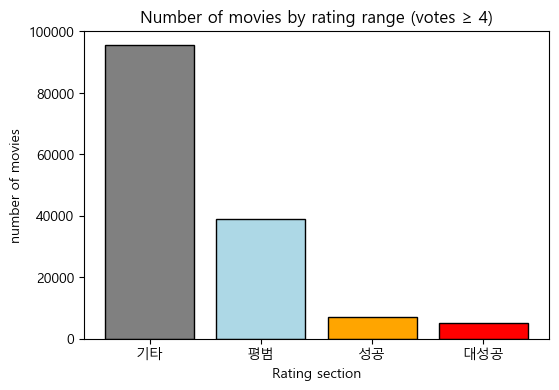

In [34]:
# 시각화
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')  # Windows: 맑은 고딕
plt.rc('axes', unicode_minus=False) 

plt.figure(figsize=(6,4))
plt.bar(category_counts.index, category_counts.values, color=["gray", "lightblue", "orange", "red"], edgecolor="black")
plt.title("Number of movies by rating range (votes ≥ 4)")
plt.xlabel("Rating section")
plt.ylabel("number of movies")
plt.show()

# 5. EDA 3 - 장르별 분석

In [35]:
'''
EDA 2번까지 내용을 정리하면 아래와 같은 결과가 나온다.
6.5 ~ 7.5점 -> 26.5%
7.5점 ~ 8.0점 -> 4.8%
8.0점 이상 -> 3.4%

그렇다면 이제는 장르별 분석을 통해 어떤 장르의 평점이 높고 낮은지 알아보고,
나아가서 구간별 평점과 전체 영화수와의 비율을 통해 효율이 어떻게 나오는지 분석을 진행한다.
'''

'\nEDA 2번까지 내용을 정리하면 아래와 같은 결과가 나온다.\n6.5 ~ 7.5점 -> 26.5%\n7.5점 ~ 8.0점 -> 4.8%\n8.0점 이상 -> 3.4%\n\n그렇다면 이제는 장르별 분석을 통해 어떤 장르의 평점이 높고 낮은지 알아보고,\n나아가서 구간별 평점과 전체 영화수와의 비율을 통해 효율이 어떻게 나오는지 분석을 진행한다.\n'

## 1. 장르 분리

In [36]:
'''
CSV 데이터 안에는 리스트([])안에 여러 장르가 담겨 있다. 
예를 들면 ["Action", "war"] 이렇게 두개가 들어있을 수 있는데 각각의 데이터를 사용하기 위해서는 장르를 분리하여 만들어줘야 한다.
이 방식을 사용할 경우 하나의 영화가 여러가지의 장르를 중복으로 하여 사용하는데 우리는 이 방식을 영화에 사용된 모든 장르를 적용하기 위해 의도적으로 사용했음
'''

'\nCSV 데이터 안에는 리스트([])안에 여러 장르가 담겨 있다. \n예를 들면 ["Action", "war"] 이렇게 두개가 들어있을 수 있는데 각각의 데이터를 사용하기 위해서는 장르를 분리하여 만들어줘야 한다.\n이 방식을 사용할 경우 하나의 영화가 여러가지의 장르를 중복으로 하여 사용하는데 우리는 이 방식을 영화에 사용된 모든 장르를 적용하기 위해 의도적으로 사용했음\n'

In [37]:
# 1. 장르 컬럼 이름 맞추기
df_cutoff = df_cutoff.rename(columns={"genres_filtered": "genre"})

# 2. explode 적용
df_genre_exp = df_cutoff.explode("genre")

# 3. NaN/빈 문자열 제거
df_genre_exp = df_genre_exp[
    df_genre_exp["genre"].notna() & (df_genre_exp["genre"].astype(str).str.strip() != "")
].copy()

## 2. 전체 구간 장르별 영화 수 및 비율

In [38]:
# 1. 전체 고유 영화 수
total_unique_movies = df_cutoff["title"].nunique()

# 2. 장르별 고유 영화 수
genre_unique_counts = (
    df_genre_exp
        .groupby("genre")["title"]
        .nunique()
        .reset_index()
        .rename(columns={"title": "unique_movie_count"})
)

# 3. 전체 영화 대비 비율(%) 계산
genre_unique_counts["percentage_unique"] = (
    genre_unique_counts["unique_movie_count"] / total_unique_movies * 100
).round(2)

# 4. 정렬
genre_unique_counts = genre_unique_counts.sort_values(
    by="unique_movie_count", ascending=False
).reset_index(drop=True)
print(genre_unique_counts)

              genre  unique_movie_count  percentage_unique
0            Comedy               40118              30.48
1           Romance               17492              13.29
2          Thriller               17432              13.25
3             Drama               16867              12.82
4            Action               15662              11.90
5            Horror               13605              10.34
6             Crime               11724               8.91
7       Documentary               11519               8.75
8         Animation               10272               7.80
9         Adventure                8631               6.56
10           Family                8593               6.53
11         TV Movie                7884               5.99
12  Science Fiction                7336               5.57
13          Fantasy                6757               5.13
14          Mystery                6719               5.11
15            Music                6241               4.

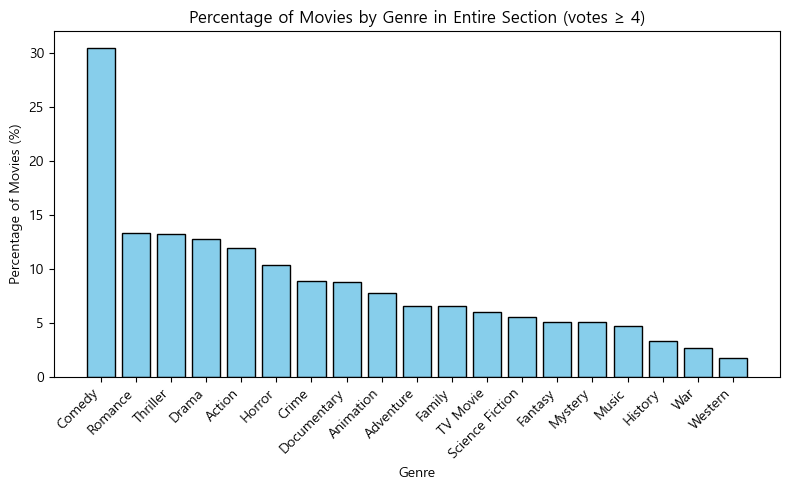

In [39]:
# 6. 시각화
plt.figure(figsize=(8,5))
plt.bar(genre_unique_counts["genre"], 
        genre_unique_counts["percentage_unique"], 
        color="skyblue", edgecolor="black")

plt.xticks(rotation=45, ha="right")
plt.title("Percentage of Movies by Genre in Entire Section (votes ≥ 4)")
plt.xlabel("Genre")
plt.ylabel("Percentage of Movies (%)")
plt.tight_layout()
plt.show()

In [40]:
'''
전체 구간을 기준으로 장르별로 비율을 확인 해 본 결과 코미디 장르가 30퍼센트로 가장많고 음악, 역사, 전쟁, 서부영화는 비율이 낮은걸 확인할 수 있다.

이제 평점을 기준으로 확인해본다면 위의 데이터와 비교하여 어떤 영화는 많이 만들어졌지만 평점이 낮은 영화가 많은 수 있고
어떤 영화는 많이 만들어지지는 않았지만 높은 평점의 영화가 많은 장르가 존재할 수 있음
다음 단계에서는 평점 별로 나누어 분석하여 효율을 분석한다.
'''

'\n전체 구간을 기준으로 장르별로 비율을 확인 해 본 결과 코미디 장르가 30퍼센트로 가장많고 음악, 역사, 전쟁, 서부영화는 비율이 낮은걸 확인할 수 있다.\n\n이제 평점을 기준으로 확인해본다면 위의 데이터와 비교하여 어떤 영화는 많이 만들어졌지만 평점이 낮은 영화가 많은 수 있고\n어떤 영화는 많이 만들어지지는 않았지만 높은 평점의 영화가 많은 장르가 존재할 수 있음\n다음 단계에서는 평점 별로 나누어 분석하여 효율을 분석한다.\n'

## 2. 전체구간 시대별 영화 장르 수 및 비율

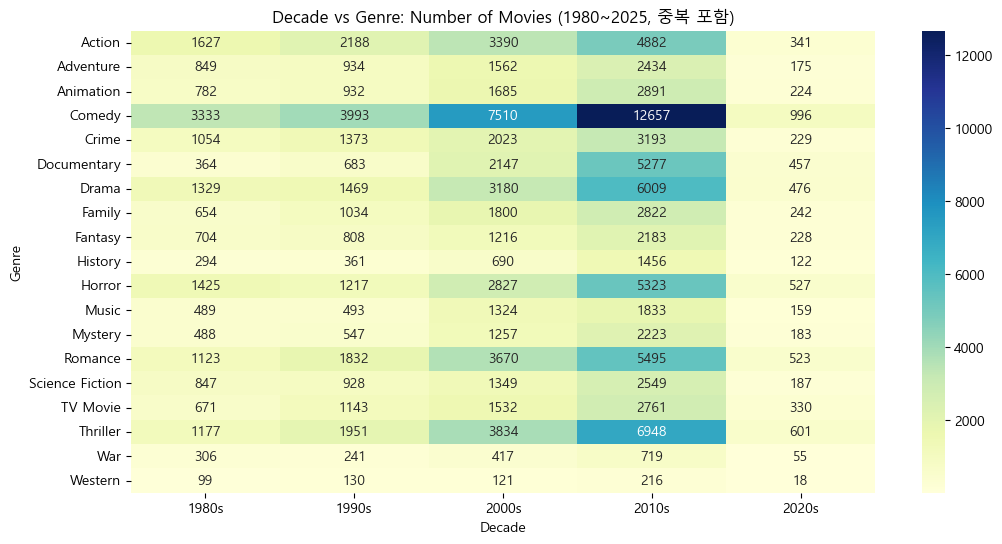

In [51]:
# 1) 연도 컬럼 만들기
df_genre_exp["year"] = pd.to_datetime(df_genre_exp["release_date"], errors="coerce").dt.year

# 2) 1980~2025 사이만 필터링
df_genre_exp = df_genre_exp[(df_genre_exp["year"] >= 1980) & (df_genre_exp["year"] <= 2025)]

# 3) Decade 컬럼 만들기
df_genre_exp["decade"] = (df_genre_exp["year"] // 10) * 10
df_genre_exp["decade"] = df_genre_exp["decade"].astype(str) + "s"

# 4) 시대별 × 장르별 영화 수 (중복 포함)
decade_genre_counts = (
    df_genre_exp.groupby(["decade", "genre"])["title"]
    .count()
    .reset_index(name="movie_count")
)

# 5) 피벗 테이블 변환
pivot_table = decade_genre_counts.pivot(index="genre", columns="decade", values="movie_count").fillna(0)

# 6) 시각화
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Decade vs Genre: Number of Movies (1980~2025, 중복 포함)")
plt.ylabel("Genre")
plt.xlabel("Decade")
plt.show()

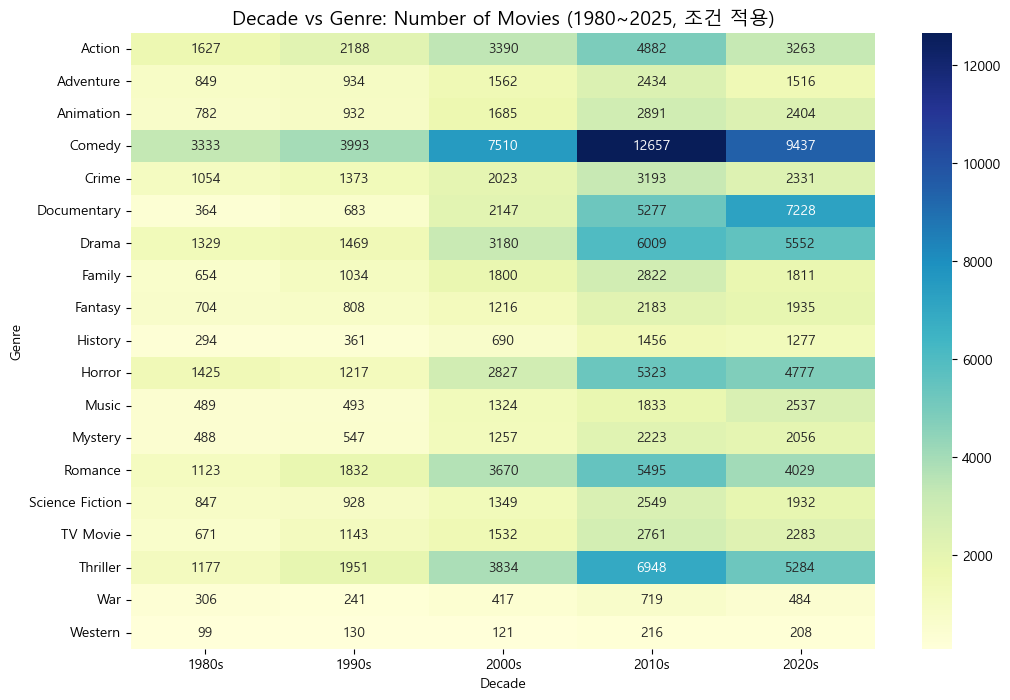

In [92]:
'''
위의 히트맵을 보면 과거부터 코미디 장르는 꾸준히 많이 만들어졌고 스릴러, 액션, 호러, 로맨스 영화가 많이 만들어졌음
다큐와 드라마는 다양한 장르와 결합되어서 제외된것이 있음에도 많은 것을 알 수 있음

하지만 이렇게 데이터를 확인했을때 2020년 이후의 영화 데이터는 최신화가 많이 되어있지 않아서 투표수가 많지않음
그래서 위와같은 조건으로 상위 퍼센트 기준 컷오프를 할 경우 1표이상이면 동일한 조건이 되어서
2020년 이후는 1표이상으로 컷오프를 하여 진행함
'''

# 1. release_date 변환
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# 2. 2020년대 (vote_count >= 1)
df_2020s = df[(df['release_date'].dt.year >= 2020) & (df['vote_count'] >= 1)]

# 3. 1980~2010년대 (vote_count >= 4)
df_1980_2010s = df[(df['release_date'].dt.year < 2020) & (df['vote_count'] >= 4)]

# 4. 합치기
df_combined = pd.concat([df_1980_2010s, df_2020s], ignore_index=True)

# 5. 장르 컬럼 정리 (explode용)
df_combined = df_combined.rename(columns={"genres_filtered": "genre"})
df_combined = df_combined.explode("genre")
df_combined = df_combined[
    df_combined["genre"].notna() & (df_combined["genre"].astype(str).str.strip() != "")
].copy()

# 6. 집계
genre_decade_counts = (
    df_decade_filtered
    .groupby(["genre", "decade"])["title"]
    .count()
    .reset_index(name="movie_count")
)

# 7. 피벗 → 히트맵용
heatmap_data = genre_decade_counts.pivot(index="genre", columns="decade", values="movie_count").fillna(0)

# 8. 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Decade vs Genre: Number of Movies (1980~2025, 조건 적용)", fontsize=14)
plt.ylabel("Genre")
plt.xlabel("Decade")
plt.show()

In [93]:
'''
2020년대도 마찬가지로 코미디, 호러, 로맨스, 스릴러, 다큐, 드라마 장르가 강세를 보이고 있고 
현재 2025년이지만 이전시대보다 많은 영화가 제작되고 있음을 알 수 있다.

다음 단계는 이 데이터를 바탕으로 평점의 기준 중에서 '평범' 이상인 비율이 얼마인지 확인해보고
그다음 평범, 성공, 대성공을 나누어 어떤 장르가 꾸준한 성공을 했는가 또는 많은 작품에도 불구하고 성공의 비율이 적은가 등등
다양하게 살펴볼 것이다.
'''

''

## 2. 평점 6.5 이상 모든 구간 장르별 영화 수 및 비율

In [99]:
'''
이번 단계에서는 평점 6.5점 이상인 모든 영화의 장르별 영화 수와 전체 대비 비율을 계산하여 '평범 이상'인 영화의 분포를 살펴봄.  
이후 평점을 세 구간으로 나누어 각 구간별 비율을 분석하고, 이를 바탕으로 시대별 흐름과 장르별 선호 경향을 예측함.
'''

"\n지금 단계에서는 6.5이상 모든 구간의 장르별 영화 수 및 비율을 구해서 '평범 이상'인 영화의 비율이 어떻게 되는 지 살펴볼 것이다.\n그 이후 세 개의 구간으로 나눈 평점 구간 별 비율을 분석해서 시대의 흐름과 장르별 선호도를 예상하려 한다.\n\n"

In [98]:
# 1. 6.5점 이상 영화 필터링
df_high = df_genre_exp[df_genre_exp["vote_average"] >= 6.5].copy()

# 2. 장르별 고유 영화 수 계산
genre_high_counts = (
    df_high.groupby("genre")["title"].nunique().reset_index()
    .rename(columns={"title": "high_unique_count"})
)

# 3. 전체 영화 수 (고유 title 기준)
total_unique_movies = df_genre_exp["title"].nunique()

# 4. 전체 대비 비율 계산 (%)
genre_high_counts["percentage_overall"] = (
    genre_high_counts["high_unique_count"] / total_unique_movies * 100
).round(2)

# 5. 내림차순 정렬
genre_high_counts = genre_high_counts.sort_values(by="percentage_overall", ascending=False)

print(genre_high_counts)

              genre  high_unique_count  percentage_overall
3            Comedy               8516                9.56
5       Documentary               5240                5.88
6             Drama               4279                4.80
13          Romance               3858                4.33
0            Action               3659                4.11
2         Animation               3602                4.04
16         Thriller               2906                3.26
7            Family               2703                3.03
11            Music               2660                2.99
4             Crime               2534                2.84
1         Adventure               2199                2.47
15         TV Movie               2159                2.42
8           Fantasy               1924                2.16
9           History               1574                1.77
14  Science Fiction               1508                1.69
10           Horror               1375                1.